In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet
from main.utils import save_experiment, load_experiment


%reload_ext autoreload
%autoreload 2

c:\Users\vince\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 5  # Number of samples to acquire in each acquisition step
num_inference_samples = 50  # Number of samples to use for inference in MC-Dropout
num_test_inference_samples = 5  
num_samples = 100000 # Number of samples to use for estimation in batchbald

test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 128  # Batch size for scoring 
training_iterations = 4096 * 6 # Number of training iterations (batches) to run

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


In [3]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = BayesianConvNet(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                num_test_inference_samples
            )
            loss += loss_fn(prediction, target)

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

    with torch.no_grad():
        model.eval()

        for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
            data = data.to(device=device)

            lower = i * pool_loader.batch_size
            upper = min(lower + pool_loader.batch_size, N)
            logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)

    with torch.no_grad():
        candidate_batch = batchbald.get_bald_batch(
            logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
        )

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [00:00<?, ?it/s]

Test set: Average loss: 0.0021, Accuracy: 7612/10000 (76.12%)


Training Set Size:  45%|████▌     | 45/100 [02:11<24:06, 26.29s/it]

Dataset indices:  [14887 25860 31981 19524 33594]
Scores:  [1.2570762080746538, 1.2057781946211683, 1.1822914491967982, 1.1785762716961254, 1.165321742461618]
Labels:  tensor([5, 6, 6, 2, 3])


Test set: Average loss: 0.0017, Accuracy: 7894/10000 (78.94%)


Training Set Size:  50%|█████     | 50/100 [04:30<22:39, 27.18s/it]

Dataset indices:  [  776 54433  2278 24440 10744]
Scores:  [1.145820523819269, 1.112182246310169, 1.0939686979812069, 1.0932006801970324, 1.055648387434773]
Labels:  tensor([0, 0, 0, 0, 7])


Test set: Average loss: 0.0015, Accuracy: 8044/10000 (80.44%)


Training Set Size:  55%|█████▌    | 55/100 [06:46<20:25, 27.23s/it]

Dataset indices:  [37605 12497 22155 13548 11406]
Scores:  [1.387942584076684, 1.2406741511173915, 1.2268208119576713, 1.2233152210827716, 1.2101442161094322]
Labels:  tensor([8, 0, 3, 4, 8])


Test set: Average loss: 0.0019, Accuracy: 7979/10000 (79.79%)


Training Set Size:  60%|██████    | 60/100 [09:03<18:11, 27.30s/it]

Dataset indices:  [52151 31772   328 59670 36892]
Scores:  [1.307985834851686, 1.236030597124699, 1.196492569629201, 1.165299091742384, 1.1536458123570186]
Labels:  tensor([9, 5, 5, 5, 1])


Test set: Average loss: 0.0016, Accuracy: 8080/10000 (80.80%)


Training Set Size:  65%|██████▌   | 65/100 [11:27<16:13, 27.80s/it]

Dataset indices:  [16902 26613 51937  5259 50736]
Scores:  [1.2336760161933784, 1.2185946758179074, 1.1857944817189607, 1.1794804010600253, 1.1730633718922934]
Labels:  tensor([2, 2, 2, 2, 2])


Test set: Average loss: 0.0014, Accuracy: 8338/10000 (83.38%)


Training Set Size:  70%|███████   | 70/100 [13:41<13:43, 27.45s/it]

Dataset indices:  [32473 11241 17269 32467 20191]
Scores:  [1.1839491458183513, 1.0621347429943357, 1.0379804434159303, 1.0209799419773917, 1.0117220900624573]
Labels:  tensor([8, 8, 2, 8, 8])


Test set: Average loss: 0.0013, Accuracy: 8322/10000 (83.22%)


Training Set Size:  75%|███████▌  | 75/100 [15:55<11:20, 27.23s/it]

Dataset indices:  [36984 15424 42148 31222 38511]
Scores:  [1.1278223609987927, 1.0701017336639933, 1.066308532998786, 1.061724681440225, 1.0555405330912768]
Labels:  tensor([5, 8, 7, 5, 6])


Test set: Average loss: 0.0010, Accuracy: 8683/10000 (86.83%)


Training Set Size:  80%|████████  | 80/100 [18:12<09:06, 27.33s/it]

Dataset indices:  [44228 49525 28420 11378  2535]
Scores:  [1.0596260216946538, 1.0481973521740566, 1.0221043609324565, 1.0204017743479799, 0.9984595105457427]
Labels:  tensor([9, 8, 1, 4, 3])


Test set: Average loss: 0.0011, Accuracy: 8571/10000 (85.71%)


Training Set Size:  85%|████████▌ | 85/100 [20:28<06:48, 27.25s/it]

Dataset indices:  [45101 44480  7856 20636  5295]
Scores:  [1.167979877812738, 1.1387607188794846, 1.0835753448553316, 1.0696918340539345, 1.061596111019881]
Labels:  tensor([5, 5, 8, 9, 4])


Test set: Average loss: 0.0010, Accuracy: 8761/10000 (87.61%)


Training Set Size:  90%|█████████ | 90/100 [22:47<04:34, 27.44s/it]

Dataset indices:  [59416 47328   424 39319 49957]
Scores:  [1.1478207978123125, 1.1102614257709287, 1.0850558392752996, 1.0790079513168136, 1.0625752859965933]
Labels:  tensor([3, 8, 9, 9, 5])


Test set: Average loss: 0.0008, Accuracy: 8889/10000 (88.89%)


Training Set Size:  95%|█████████▌| 95/100 [25:29<02:24, 28.98s/it]

Dataset indices:  [24416 55128 23434 25783 18240]
Scores:  [1.027956026336538, 1.0255406982760356, 1.021273391633068, 1.00988963365211, 1.0074447158415576]
Labels:  tensor([8, 8, 5, 0, 3])


Test set: Average loss: 0.0008, Accuracy: 8840/10000 (88.40%)


Training Set Size: 100%|██████████| 100/100 [28:13<00:00, 30.09s/it]

Dataset indices:  [42221   813 16036 32880  3644]
Scores:  [1.116252837355666, 1.0832360593485681, 1.0686570135491935, 1.0640626741446475, 1.05782307283321]
Labels:  tensor([5, 2, 8, 0, 1])


Test set: Average loss: 0.0007, Accuracy: 9013/10000 (90.13%)


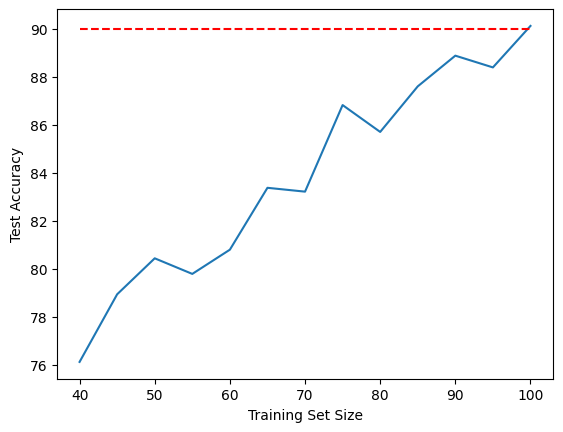

In [4]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')

plt.show()

## Storing results

In [5]:
params_dict = {
    'num_initial_samples': num_initial_samples,
    'num_classes': num_classes,
    'max_training_samples': max_training_samples,
    'acquisition_batch_size': acquisition_batch_size,
    'num_inference_samples': num_inference_samples,
    'num_test_inference_samples': num_test_inference_samples,
    'num_samples': num_samples,
    'test_batch_size': test_batch_size,
    'batch_size': batch_size,
    'scoring_batch_size': scoring_batch_size,
    'training_iterations': training_iterations
}

save_experiment('Lenet5-simple_BALD', params_dict, {
    'test_accs': test_accs,
    'test_loss': test_loss,
    'added_indices': added_indices
})